# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from matplotlib import rc
from matplotlib import cm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)  
import shap
xscaler = MinMaxScaler()

In [2]:
file_path = '../input_data/pspeo_master.xlsx'
model_output = 'grain'
# import data frame for pre-processing
df = pd.read_excel(file_path)
df.head()

,sample,solv_ratio,add_type,swell_ratio,gisaxs_domain,gisaxs_fwhm,afm_domain,afm_grain
0,I_A_AC,80/20,Chloronaphthalene,1.00,31.302630,0.003697,33.737303,0.0048
1,I_A025,80/20,Chloronaphthalene,1.25,33.805848,0.003136,35.151690,0.0047
2,I_A050,80/20,Chloronaphthalene,1.50,34.176062,0.002970,35.397797,0.0534
3,I_A075,80/20,Chloronaphthalene,1.75,34.383751,0.003451,34.603726,0.0425
4,I_A_100,80/20,Chloronaphthalene,2.00,31.674148,0.005122,33.786210,0.0244


# Data pre-processing

In [3]:
# Assign input variables and target variable, eliminating static valuesp
inputs = df.loc[:, ['solv_ratio', 'swell_ratio', 'add_type']]
target = df['afm_grain']

# Define mapping for solv_ratio
type_mapping = {100: 1.0, '90/10': 0.9, '80/20': 0.8, '70/30': 0.7, '60/40': 0.6, '50/50': 0.5}
inputs['solv_ratio'] = inputs['solv_ratio'].replace(type_mapping)

# Encode categorical input 'add_type'
le_addType = LabelEncoder()
inputs['add_type'] = le_addType.fit_transform(inputs['add_type'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=10)

# Scale the x data for better fitting
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

# Grid-Search

In [4]:
from joblib import dump, load
# Convert cv_results_ to DataFrame

# Save the trained model
best = load(f'raw_models/{model_output}.joblib')

In [5]:
train_r2 = best.score(X_train, y_train)
test_r2 = best.score(X_test, y_test)

print(f'Training r2: {train_r2}')
print(f'Testing r2: {test_r2}')

rfr_train = best.predict(X_train)
rfr_test = best.predict(X_test)

# Define the output path for figures
output_path = f'final_figs/{model_output}/'

Training r2: 0.4591608502253153
Testing r2: 0.032634241548510246


# Visualize the results

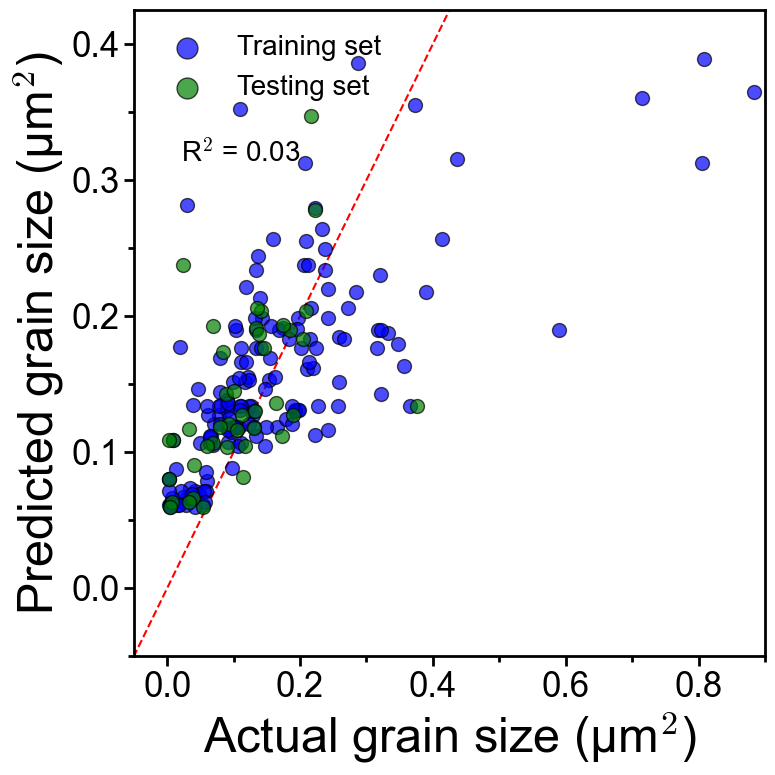

In [6]:
# Define the figure title
fig_title = f'{model_output}_avp_poster'
textstr = f'R$^2$ = {test_r2:.2f}'

%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=25)   
rc('xtick.major', size=7)  
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=25)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=25) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True}) 
plt.rcParams['font.family'] = 'Arial'

#This sets the size of the entire image
fig,ax = plt.subplots(figsize=(8,8))
# Add a diagonal line for reference (perfect prediction)
plt.plot([-1, 100], [-1, 100], linestyle='--', color='red', zorder=0)
# Create a scatter plot
plt.scatter(y_train, rfr_train, color='blue', edgecolors='black', label='Training set', alpha=0.7, s=100)
plt.scatter(y_test, rfr_test, color='green', edgecolors='black', label='Testing set', alpha=0.7, s=100)

plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)
#This sets the numerical distance between each major tick on the x axis
ax.xaxis.set_major_locator(MultipleLocator(.2))
#This sets the number of intervals between major ticks on the x axis
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#This sets the numerical distance between each major tick on the y axis
ax.yaxis.set_major_locator(MultipleLocator(.1))
#This sets the number of intervals between major ticks on the x axis
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# Add labels and a legend
plt.ylabel("Predicted grain size (\u03BCm$^{2}$)", fontsize='35')
plt.xlabel("Actual grain size (\u03BCm$^{2}$)", fontsize='35')

# Set legend background color to white
legend = plt.legend(fontsize=20, markerscale=1.5, frameon=False, loc='upper left')
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.xlim(-0.05, 0.9)
plt.ylim(-0.05, 0.425)
# Show the plot
plt.tight_layout()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0)
# place a text box in upper left in axes coords
ax.text(0.075, 0.8, textstr, transform=ax.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)

# plt.savefig(output_path + fig_title, format='pdf')
plt.show()

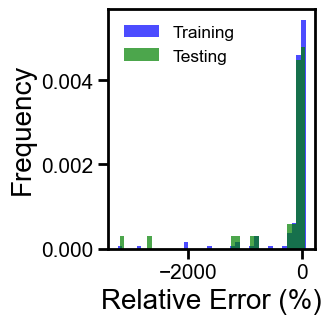

In [8]:
# Define the figure title
fig_title = f'{model_output}_relative_error_histogram'

# Calculate relative error as percent
rel_err_train_pct = 100 * (y_train - rfr_train) / y_train
rel_err_test_pct = 100 * (y_test - rfr_test) / y_test

# set formatting for plots
%matplotlib inline
rc('text', usetex=False)
rc('mathtext', fontset='cm')
rc('xtick', labelsize=15)  
rc('xtick.major', size=7)   
rc('xtick.minor', size=4)
rc('xtick.major', width=2)
rc('xtick.minor', width=2)
rc('ytick.major', width=2)
rc('ytick.minor', width=2)
rc('ytick', labelsize=15)
rc('ytick.major', size=7)
rc('ytick.minor', size=4)
rc('axes', labelsize=15) 
rc('axes', linewidth=2) 
rc('font',family='sans serif')
rc('font', style='normal')
rc('font', weight='500')
rc('font', size='15')
rc('axes', labelweight='500')
rc('axes.spines', **{'right':True, 'top':True})   
plt.rcParams['font.family'] = 'Arial'
# Create a histogram of relative errors
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# ax.xaxis.set_major_locator(MultipleLocator(5))
# ax.xaxis.set_minor_locator(AutoMinorLocator(2))
# ax.yaxis.set_major_locator(MultipleLocator(0.2))
# ax.yaxis.set_minor_locator(AutoMinorLocator(2))

bins = 40  # adjust as needed
plt.hist(rel_err_train_pct, bins=bins, alpha=0.7, color='blue', label='Training', density=True)
plt.hist(rel_err_test_pct, bins=bins, alpha=0.7, color='green', label='Testing', density=True)

plt.xlabel("Relative Error (%)", fontsize='20')
plt.ylabel("Frequency", fontsize='20')

# Set legend background color to white
legend = plt.legend(fontsize='12.5', frameon = False)
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('none')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# Add black borders to the plot
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.tight_layout()
plt.savefig(output_path + fig_title, format='pdf', transparent=True)
plt.show()

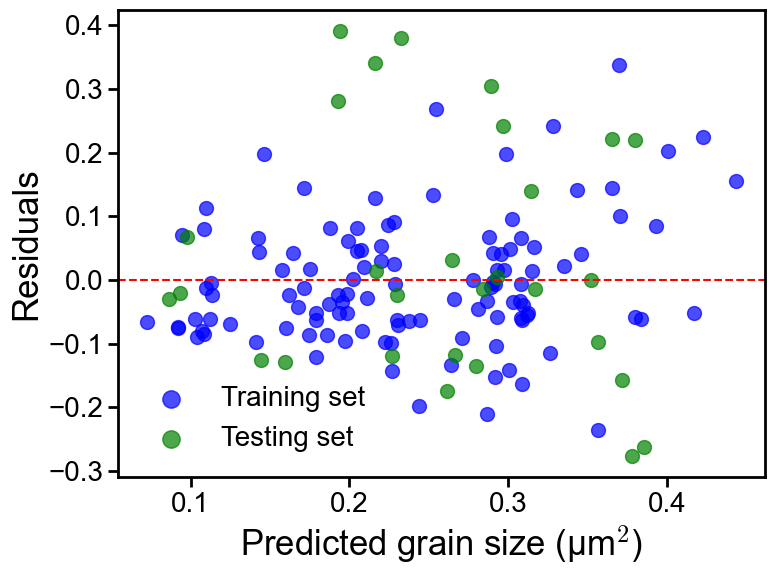

In [9]:
# Define the figure title
fig_title = f'{model_output}_residuals.png'

res_train = y_train - rfrtrain
res_test = y_test - rfreval

# Create a residuals plot
plt.figure(figsize=(8, 6))
plt.scatter(rfrtrain, res_train, color='blue', alpha=0.7, label='Training set', s=100)
plt.scatter(rfreval, res_test, color='green', alpha=0.7, label='Testing set', s=100)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted grain size (\u03BCm$^{2}$)", fontsize='25')
plt.ylabel("Residuals", fontsize='25')
# Set legend background color to white
legend = plt.legend(fontsize='20', markerscale=1.25, frameon=False)
legend.get_frame().set_facecolor('white')

# Set the background color to white
plt.gca().set_facecolor('white')

# Remove gridlines
plt.grid(False)

# Add tickmarks to x and y axes
plt.tick_params(axis='both', which='both', reset=True, top=False, right=False)

# # Add black borders to the grid
plt.gca().spines['top'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['right'].set_color('black')

plt.grid(False)
plt.tight_layout()
plt.savefig(output_path + fig_title, dpi=500, format='png')
plt.show()